# Imports

In [1]:
# ALL
import keras
import os
import random

# AS
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# FROM
from contextlib import redirect_stdout
from keras.models import Sequential
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, GlobalAveragePooling3D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


/opt/homebrew/lib/python3.11/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# tf.keras.backend.clear_session()

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.13.0
Num GPUs Available:  0


# Loading Data

In [3]:
main_root_directory = "/Users/izzymohamed/Desktop/MLPData"
single_modal_directory = os.path.join(main_root_directory, "MRI")

In [4]:
# Create new folder to save the results of the model
folder_name = single_modal_directory.split('/')[-2] + "/" + single_modal_directory.split('/')[-1]
results_folder = os.path.join(main_root_directory, 'Single Modal', "Results", folder_name, "Resnet50NoWeights")

In [5]:
results_folder

'/Users/izzymohamed/Desktop/MLPData/Single Modal/Results/MLPData/MRI/Resnet50NoWeights'

In [6]:
# Create the collect df
def collect_files_from_directories(main_root_directory):
    categories = [
        "non-demented",
        "very-mild-dementia",
        "mild-dementia",
        "moderate-dementia",
        "unknown",
    ]
    
    # Initialize an empty list to collect file info
    collected_files = []

    # Walk through the directory structure
    for root, dirs, files in os.walk(main_root_directory):
        # Check if the current folder is one of the categories
        if os.path.basename(root) in categories:
            for file in files:
                # Construct the full file path
                file_path = os.path.join(root, file)
                # Collect the file path and category (folder name)
                collected_files.append((file_path, os.path.basename(root)))
    
    # Convert the collected file info into a DataFrame
    df = pd.DataFrame(collected_files, columns=['FilePath', 'Category'])
    
    return df

In [7]:
# convert collect_files_from_directories_df to dictionary where Category is the key and the value is the list of file paths
def convert_df_to_dict(df):
    # Initialize an empty dictionary
    file_dict = {}
    
    # Loop through the unique categories
    for category in df['Category'].unique():
        # Collect the file paths for the current category
        file_dict[category] = df[df['Category'] == category]['FilePath'].values
    
    return file_dict

In [8]:
collect_files_from_directories_df = collect_files_from_directories(single_modal_directory)
images_dict = convert_df_to_dict(collect_files_from_directories_df)

# Now you can access the images using the keys in images_dict
non_demented = images_dict['non-demented'] if 'non-demented' in images_dict else []
very_mild_demented = images_dict['very-mild-dementia'] if 'very-mild-dementia' in images_dict else []
mild_demented = images_dict['mild-dementia'] if 'mild-dementia' in images_dict else []
moderate_demented = images_dict['moderate-dementia'] if 'moderate-dementia' in images_dict else []
unknown = images_dict['unknown'] if 'unknown' in images_dict else []

# If you need to print the count for each category:
for key, value in images_dict.items():
    print(f"{key}: {len(value)} images")


non-demented: 411631 images
moderate-dementia: 14568 images
unknown: 52791 images
very-mild-dementia: 122133 images
mild-dementia: 43366 images


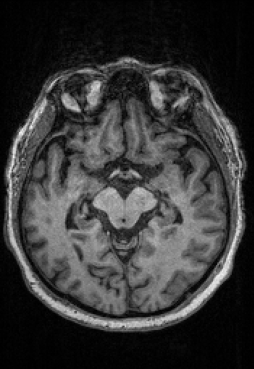

In [9]:
Image.open(str(non_demented[0]))

In [10]:
print(f"Non-demented: {len(non_demented)}")
print(f"Very mild dementia: {len(very_mild_demented)}")
print(f"Mild dementia: {len(mild_demented)}")
print(f"Moderate dementia: {len(moderate_demented)}")
print(f"Unknown: {len(unknown)}")

Non-demented: 411631
Very mild dementia: 122133
Mild dementia: 43366
Moderate dementia: 14568
Unknown: 52791


In [11]:
def display_images_with_text(images, category_name,):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    display_count = 0 # Initialize a counter for displayed images

    if len(images) == 0:
        print("No images to display")
        return
    
    # Ensure to display up to 3 images only
    for i in range(min(3, len(images))):
        if display_count < 3: # Check if less than 3 images have been displayed
            img_path = images[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, display_count + 1) # Use display_count for subplot indexing
            plt.imshow(img)
            plt.axis('off')
            
            # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {display_count + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))
            
            display_count += 1 # Increment the displayed images counter

    plt.show()

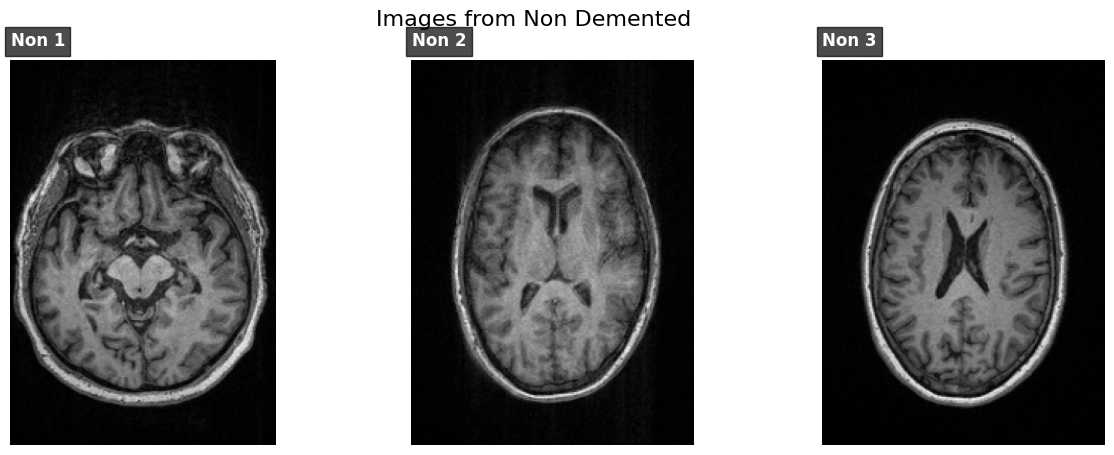

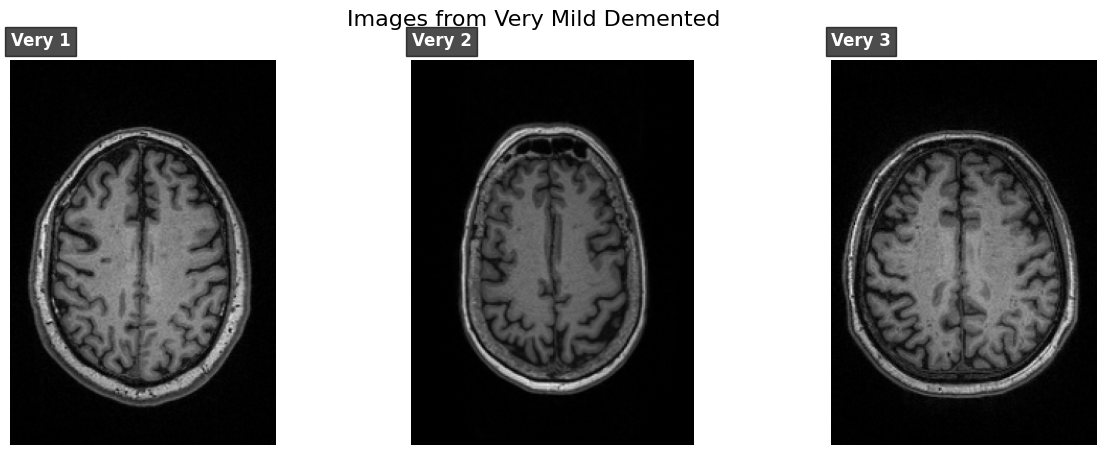

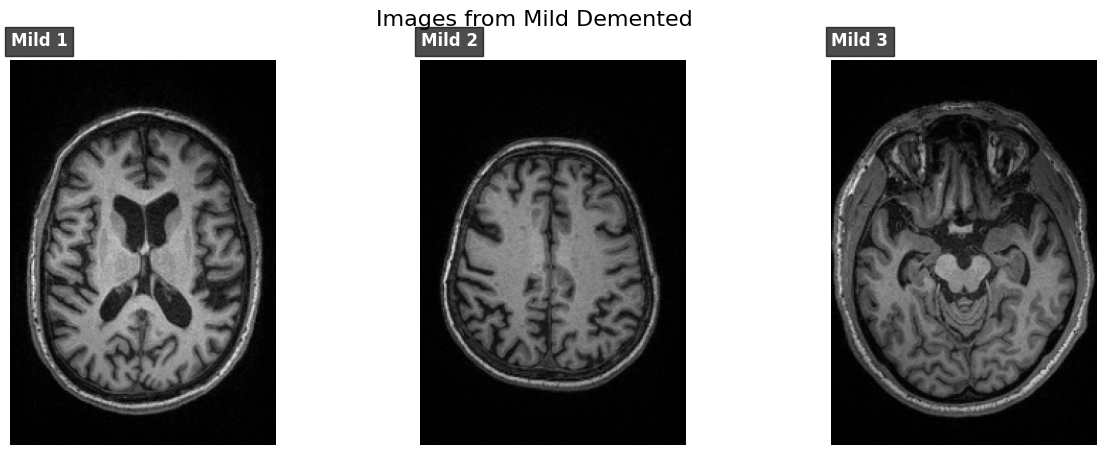

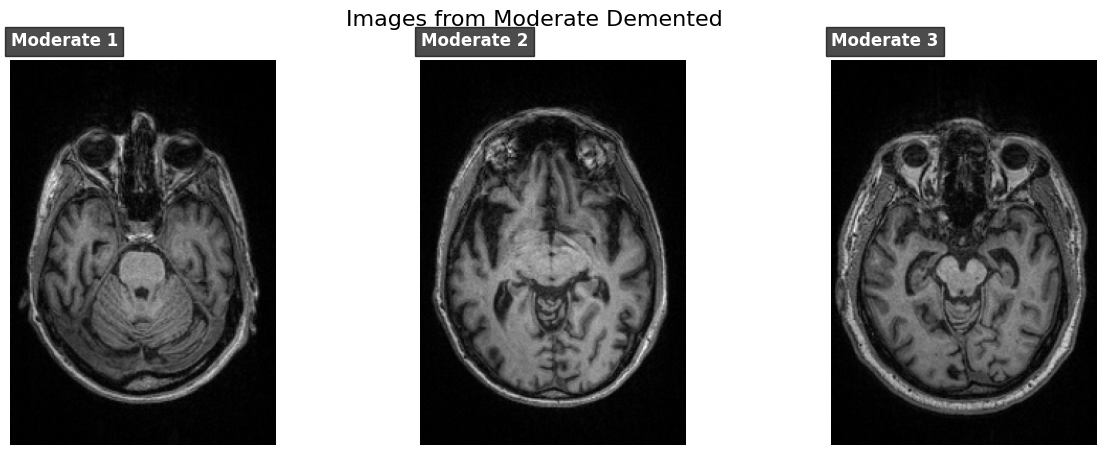

In [12]:
# Display images with text for each category
display_images_with_text(non_demented, "Non Demented")
display_images_with_text(very_mild_demented, "Very Mild Demented")
display_images_with_text(mild_demented, "Mild Demented")
display_images_with_text(moderate_demented, "Moderate Demented")

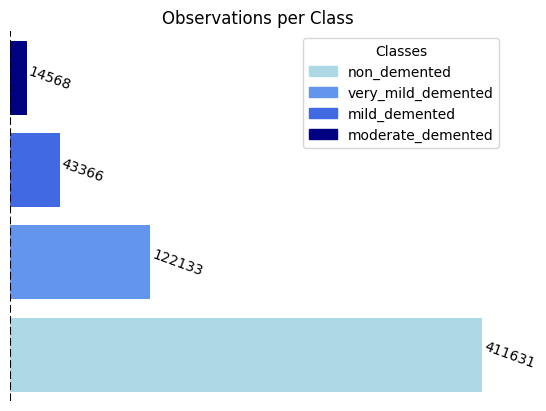

In [13]:
# Defining class_names, frequencies
frequencies = [len(non_demented),  len(very_mild_demented), len(moderate_demented), len(mild_demented),]
class_names = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]

# Sorting class_names and frequencies in descending order
sorted_indices = np.argsort(frequencies)[::-1]
class_names = np.array(class_names)[sorted_indices]
frequencies = np.array(frequencies)[sorted_indices]

# Navy blue gradient color palette with 4 distinct colors
navy_blue_palette = LinearSegmentedColormap.from_list("navy_blue_palette", ["lightblue", "cornflowerblue", "royalblue", "navy"], N=4)

# Bar plot with adjusted y-axis limits and navy blue gradient colors
fig, ax = plt.subplots()
bp = ax.barh(np.arange(len(class_names)), frequencies, color=navy_blue_palette(np.linspace(0, 1, len(class_names))))

# Adjusted y-axis limits
ax.set_ylim(-0.5, len(class_names)-0.5)

# Class names as y-axis labels
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)

# Hide axes
ax.axis('off')

# Frequency values to the right of each bar with a reduced offset
for i, frequency in enumerate(frequencies):
    ax.text(frequency + 0.1, i, frequency, ha='left', va='center', rotation=-20)

# Vertical line at 0 for clarity
ax.axvline(x=0, linestyle='--', color='black')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=navy_blue_palette(i)) for i in range(4)]
ax.legend(handles, class_names, loc="upper right", title="Classes")

# Plot title
plt.title("Observations per Class")

plt.show()

# Data Preprocessing

In [14]:
# Set seed for random sampling
random.seed(42)

def train_test_split_fun(class_df):
    if class_df != []:
        return train_test_split(class_df, test_size=0.2, random_state=42)
    else:
        return [], []

In [15]:
# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split_fun(moderate_demented)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split_fun(mild_demented)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split_fun(very_mild_demented)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split_fun(non_demented)

/var/folders/jy/jw39h2vx0cb_5g4scvrzm7p00000gn/T/ipykernel_67701/1843851176.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if class_df != []:


In [16]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

329304
97706
34692
11654


In [17]:
def random_choices_sample(dataset, target_samples):
    if dataset == []:
        return []
    else:
        if len(dataset) < target_samples:
            # Oversample small classes
            return random.choices(dataset, k=target_samples)
        else: 
            # Undersample large classes
            return random.sample(list(dataset), k=target_samples)

In [18]:
print(len(very_mild_demented_train))

97706


In [19]:
# Specify the target number of samples for each class
target_samples = 10000

# Oversample small classes
moderate_demented_samp = random_choices_sample(moderate_demented_train, target_samples)
mild_demented_samp = random_choices_sample(mild_demented_train, target_samples)

# Undersample large classes
very_mild_demented_samp = random_choices_sample(very_mild_demented_train, target_samples)
non_demented_samp = random_choices_sample(non_demented_train, target_samples)

/var/folders/jy/jw39h2vx0cb_5g4scvrzm7p00000gn/T/ipykernel_67701/1971252913.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if dataset == []:


In [20]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

10000
10000
10000
10000


In [21]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

82327
24427
8674
2914


In [22]:
# Specify the target number of samples for each class
target_samples = 5000

# Undersample large classes
mild_demented_test = random_choices_sample(mild_demented_test, target_samples)
very_mild_demented_test = random_choices_sample(very_mild_demented_test, target_samples)
non_demented_test = random_choices_sample(non_demented_test, target_samples)

/var/folders/jy/jw39h2vx0cb_5g4scvrzm7p00000gn/T/ipykernel_67701/1971252913.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if dataset == []:


In [23]:
# One-hot encoder for class labels 
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [24]:
# Mapping categories to their labels
categories = {
    'non_demented_samp': 0,
    'very_mild_demented_samp': 1,
    'mild_demented_samp': 2,
    'moderate_demented_samp': 3
}

In [25]:
# Empty lists to store the data and the class labels (result) in
data = []
result = []

for category, label in categories.items():
    # Assuming each category variable (e.g., non_demented_samp) is defined and accessible via a dictionary-like structure
    print(category)
    for path in globals()[category]:
        # if path could not be opened, skip it
        try:
            img = Image.open(path)
        except UnidentifiedImageError:
            print(f"Unable to identify image file: {path}")
            continue
        # print(f"{img}: {np.array(img).shape}")
        img = img.resize((128, 128))
        img_array = np.array(img)[:,:,:3]
        # print(f"{img}: {img_array.shape}")
        if img_array.shape == (128, 128, 3):
            data.append(img_array)
            result.append(encoder.transform([[label]]).toarray())
            # print(f"{data}: {result}")
    print(f"{category}: {np.array(data).shape}")


non_demented_samp
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30966_ses-d1267_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS31345_sess-d0034_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS31125_ses-d0049_acq-TSE_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS31013_ses-d0628_acq-TSE_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30633_sess-d3636_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/S

In [26]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(39833, 128, 128, 3)

In [27]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format 
result = result.reshape((data.shape[0],4)) 

# Check shape 
result.shape

(39833, 4)

In [28]:
# Split in validation and train data 
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [29]:
# Mapping categories to their labels
test_categories = {
    'non_demented_test': 0,
    'very_mild_demented_test': 1,
    'mild_demented_test': 2,
    'moderate_demented_test': 3
}

# Empty lists to store the data and the class labels (result) in
data_test = []
result_test = []

for category, label in test_categories.items():
    # Assuming each category variable (e.g., non_demented_samp) is defined and accessible via a dictionary-like structure
    print(category)
    for path in globals()[category]:
        try:
            img = Image.open(path)
        except UnidentifiedImageError:
            print(f"Unable to identify image file: {path}")
            continue
        # print(f"{img}: {np.array(img).shape}")
        img = img.resize((128, 128))
        img_array = np.array(img)[:,:,:3]
        # print(f"{img}: {img_array.shape}")
        if img_array.shape == (128, 128, 3):
            data_test.append(img_array)
            result_test.append(encoder.transform([[label]]).toarray())
            # print(f"{data}: {result}")
    print(f"{category}: {np.array(data_test).shape}")

non_demented_test
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30929_ses-d0115_acq-TSE_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS31430_sess-d0060_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30178_ses-d1384_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30823_ses-d2277_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Slice_100_sub-OAS30135_ses-d2367_acq-TSE_T2w_axial_img.png
Unable to identify image file: /Users/izzymohamed/Desktop/MLPData/MRI/OASIS3/T2w/Preprocessed_Categories/non-demented/Sl

In [30]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(17857, 128, 128, 3)

In [31]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4)) 
result_test.shape

(17857, 4)

In [32]:
# Change names to x_test and y_test 
x_test = data_test
y_test = result_test
y_test_int = np.argmax(y_test, axis=1)

In [33]:
# Create the train, validation init data
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

In [34]:
# Print the shapes of the train, validation init data
print(y_train_int)
print(y_val_int)

[0 2 0 ... 3 0 1]
[1 0 2 ... 1 1 3]


# Training

In [35]:
# Download the pre-trained model and weights
# base_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(128,128,3),
#                    pooling='avg',classes=100,
#                    weights='imagenet')

# Change baseline model so it is not pretrained
base_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=100,
                   weights=None)


In [36]:
base_model.trainable = True

# This function is used to set the layers to be trainable
def get_pretrained():
    # Call the base model
    model = Sequential([base_model, Dense(4, activation='softmax')])

    # model = tf.keras.Sequential([
    #     base_model,
    #     tf.keras.layers.GlobalAveragePooling2D(),
    #     tf.keras.layers.Dense(256, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(4, activation='softmax')  # Adjust 'num_classes' based on your task
    # ])
    # Input shape = [width, height, color channels]
    
    # Head
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(128, activation='relu')(x)
    
    # Final Layer (Output)
    # output = layers.Dense(4, activation='sigmoid')(x)
    
    # model = keras.Model(outputs=output)
    
    return model

In [37]:
# Call the model
model_pretrained = get_pretrained()

# Compile the model
model_pretrained.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='accuracy')

# Display model summary
model_pretrained.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 23542788 (89.81 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [39]:
# Train the model
model_pretrained.fit(x_train, y_train_int, epochs=10, batch_size=32, # 5 epochs to reduce computation time
                        validation_data=(x_val, y_val_int))

Epoch 1/10
996/996 [==============================] - 4026s 4s/step - loss: 1.1920 - accuracy: 0.4564 - val_loss: 1.2036 - val_accuracy: 0.4433
Epoch 2/10
996/996 [==============================] - 4219s 4s/step - loss: 1.0974 - accuracy: 0.5137 - val_loss: 1.1202 - val_accuracy: 0.5277
Epoch 3/10
996/996 [==============================] - 3725s 4s/step - loss: 0.9835 - accuracy: 0.5732 - val_loss: 0.9848 - val_accuracy: 0.5750
Epoch 4/10
996/996 [==============================] - 3993s 4s/step - loss: 0.8473 - accuracy: 0.6433 - val_loss: 0.9972 - val_accuracy: 0.5589
Epoch 5/10
996/996 [==============================] - 4204s 4s/step - loss: 0.6971 - accuracy: 0.7151 - val_loss: 0.8687 - val_accuracy: 0.6479
Epoch 6/10
996/996 [==============================] - 4209s 4s/step - loss: 0.5796 - accuracy: 0.7687 - val_loss: 0.8493 - val_accuracy: 0.6748
Epoch 7/10
 92/996 [=>............................] - ETA: 1:10:43 - loss: 0.4373 - accuracy: 0.8298

KeyboardInterrupt: 

In [ ]:
# Save the model and the results
model_pretrained.save(results_folder + '/model_pretrained.h5')

# Save output in txt file
with open(results_folder + '/model_pretrained.txt', 'w') as f:
    with redirect_stdout(f):
        model_pretrained.summary()

# Evaluate

In [ ]:
# Evaluate the model on the test data using `evaluate`
test_loss, test_accuracy = model_pretrained.evaluate(x_test, y_test_int)

In [ ]:
# Save the evaluation results
with open(results_folder + '/model_pretrained_evaluation.txt', 'w') as f:
    with redirect_stdout(f):
        print('Test loss:', test_loss)
        print('Test accuracy:', test_accuracy)

# Prediction
To calculate additional metrics, you'll need the model's predictions on the test set.

In [ ]:
# Predict the test data
y_pred = model_pretrained.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report

## Calculate

### Classification Report
The classification report will give you precision, recall, and F1-score for each class.

In [ ]:
# Check to see if classes are all in the folder if not remove class from class_names list
class_names = [class_names[i] for i in np.unique(y_test_int)]

In [ ]:
# Print the classification report
print(classification_report(y_test_int, y_pred_classes, target_names=class_names))

In [ ]:
# Save the classification report
with open(results_folder + '/model_pretrained_classification_report.txt', 'w') as f:
    with redirect_stdout(f):
        print(classification_report(y_test_int, y_pred_classes, target_names=class_names))

### Confusion Matrix
The confusion matrix provides an overview of the true vs. predicted labels.

In [ ]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_classes)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(results_folder + '/model_pretrained_confusion_matrix.png')  
plt.show()

### ROC Curve and AUC
For a multi-class classification problem, you'll need to calculate the ROC curve and AUC for each class.


In [ ]:
# Convert y_test to one-hot for ROC calculation
y_test_one_hot = tf.keras.utils.to_categorical(y_test_int, num_classes=len(class_names))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Save the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(results_folder + '/model_pretrained_roc_curve_for_all_classes.png')
plt.show()

In [ ]:
# Plot ROC curve for each class
for i in range(len(class_names)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(class_names[i]))
    plt.legend(loc="lower right")
    plt.savefig(results_folder + f'/model_pretrained_roc_curve_{class_names[i]}.png')
    plt.show()


### Precision-Recall curve

In [ ]:
# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_one_hot[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_one_hot[:, i], y_pred[:, i])

In [ ]:
# Display Precision-Recall curve for each class
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} ({average_precision[i]:0.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="lower right")
plt.savefig(results_folder + '/model_pretrained_precision_recall_curve_for_all_classes.png')
plt.show()

In [ ]:
# Plot Precision-Recall curve for each class
for i in range(len(class_names)):
    plt.figure()
    plt.plot(recall[i], precision[i], label='Precision-Recall curve (area = %0.2f)' % average_precision[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend(loc="lower right")
    plt.savefig(results_folder + f'/model_pretrained_precision_recall_curve_{class_names[i]}.png')
    plt.show()

### Compute the MMCE

In [ ]:
# Compute the MMCE
mmce = 1 - test_accuracy
print(f'MMCE: {mmce:.4f}')


### Logarithmic Loss

In [ ]:
print(y_test_one_hot.shape)
print(y_pred[:,:3].shape)

In [ ]:
# Create a CategoricalCrossentropy instance
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compute the log loss
log_loss = loss_fn(y_test_one_hot[:,:3], y_pred[:,:3]).numpy()  # Use .numpy() to convert to a scalar

print(f'Log loss: {log_loss:.4f}')


### Mean Absolute Error

In [ ]:
# Compute the mean absolute error
mae = tf.keras.losses.mean_absolute_error(y_test_one_hot[:,:3], y_pred[:,:3])
mean_mae = tf.reduce_mean(mae)  # Calculate the mean of the MAE values

print(f'Mean absolute error: {mean_mae:.4f}')

### Mean Squared Error

In [ ]:
# Compute the mean squared error
mse = tf.keras.losses.mean_squared_error(y_test_one_hot[:,:3], y_pred[:,:3])
mean_mse = tf.reduce_mean(mse)  # Calculate the mean of the MAE values

print(f'Mean absolute error: {mean_mse:.4f}')

### F1 Score

In [ ]:
print(y_test_int.dtype)
print(y_pred_classes.dtype)

In [ ]:
# Compute F1 score
f1score = f1_score(y_test_int, y_pred_classes, average='weighted')

print(f'F1 score: {f1score:.4f}')

## Save

In [ ]:
# Save all the results in a txt file
with open(results_folder + '/model_pretrained_results.txt', 'w') as f:
    with redirect_stdout(f):
        print('Test loss:', test_loss)
        print('Test accuracy:', test_accuracy)
        print(classification_report(y_test_int, y_pred_classes, target_names=class_names))
        print('MMCE:', mmce)
        print('Log loss:', log_loss)
        print('Mean absolute error:', mean_mae)
        print('Mean squared error:', mean_mse)
        print('F1 score:', f1_score)